In [1]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np

In [2]:
df=pd.read_csv(r'2004 to 2007 comple.csv')
df

,DATE,RAINFALL,FLOW (M3/S),FLOW-OBSERVED (M3/S)
0,9-Mar-04,0.1590,3990,4281
1,10-Mar-04,1.1065,3990,4270
2,11-Mar-04,0.0000,3990,4260
3,12-Mar-04,0.0000,3990,4249
4,13-Mar-04,0.0000,3990,4238
...,...,...,...,...
1448,25-Feb-08,0.0205,4304,3705
1449,26-Feb-08,0.0000,4294,3709
1450,27-Feb-08,0.0000,4296,3712
1451,28-Feb-08,0.0000,4288,3716


In [3]:
df.index=pd.to_datetime(df['DATE'])
df.head()

C:\Users\SHANTO-PC\AppData\Local\Temp\ipykernel_15140\2451772597.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index=pd.to_datetime(df['DATE'])


,DATE,RAINFALL,FLOW (M3/S),FLOW-OBSERVED (M3/S)
DATE,,,,
2004-03-09,9-Mar-04,0.1590,3990,4281
2004-03-10,10-Mar-04,1.1065,3990,4270
2004-03-11,11-Mar-04,0.0000,3990,4260
2004-03-12,12-Mar-04,0.0000,3990,4249
2004-03-13,13-Mar-04,0.0000,3990,4238


<Axes: xlabel='DATE'>

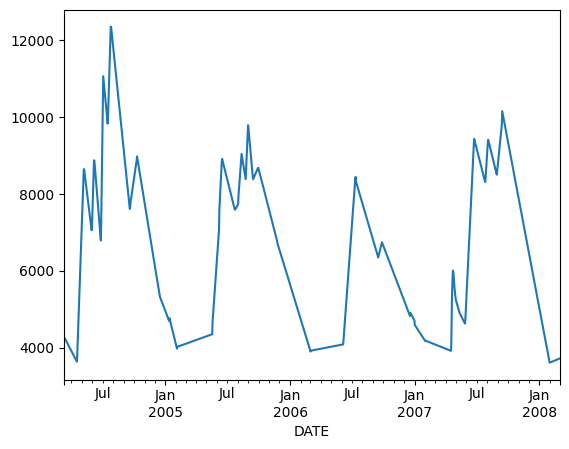

In [4]:
flow=df['FLOW-OBSERVED (M3/S)'[:100]]
flow.plot()

In [5]:
def df_to_x_y(df, window_size=3):
    df_as_np=df.to_numpy()
    x=[]
    y=[]
    for i in range (len(df_as_np)-window_size):
        row=[[a] for a in df_as_np[i:i+3]]
        x.append(row)
        label= df_as_np[i+3]
        y.append(label)
    return np.array(x), np.array(y)

In [6]:
Window=3
x,y= df_to_x_y(flow,Window)
x.shape, y.shape

((1450, 3, 1), (1450,))

In [7]:
x_train, y_train=x[:800],y[:800]
x_val, y_val=x[800:1100],y[800:1100]
x_test, y_test=x[1100:],y[1100:]

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,CSVLogger
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

models= Sequential()
models.add(InputLayer((50,1)))
models.add(LSTM(1028))
models.add(Dense(512,'relu'))
models.add(Dense(256,'relu'))
models.add(Dense(128,'relu'))
models.add(Dense(64,'relu'))
models.add(Dense(32,'relu'))
models.add(Dense(1,'linear'))

models.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1028)           │     4,235,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,936,801 (18.83 MB)

 Trainable params: 4,936,801 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cp= ModelCheckpoint('models.keras', save_best_only=True)
models.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=.0001),metrics=[RootMeanSquaredError()])

In [10]:
csv=tf.keras.callbacks.CSVLogger(
   '2004 to 2007 comple.log',  append=True)

early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

models.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=200, callbacks=[cp,csv,early_stop])

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 47875936.0000 - root_mean_squared_error: 6918.1367 - val_loss: 34179380.0000 - val_root_mean_squared_error: 5846.3135
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 46433256.0000 - root_mean_squared_error: 6813.3672 - val_loss: 34090172.0000 - val_root_mean_squared_error: 5838.6792
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 44949520.0000 - root_mean_squared_error: 6699.0200 - val_loss: 33784884.0000 - val_root_mean_squared_error: 5812.4766
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 45967916.0000 - root_mean_squared_error: 6779.3457 - val_loss: 32883276.0000 - val_root_mean_squared_error: 5734.3940
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 44931704.0000 - root_mean_squared_error: 6702.3438 - val_loss: 30613508.0000 - val_root_mean_squared_error: 5532.9473
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 40381368.0000 - root_mean_squared_error: 6353.4727

In [ ]:
from tensorflow.keras.models import load_model

models=load_model('models.keras')

In [12]:
train= models.predict(x_train).flatten()
results=pd.DataFrame(data={"Actuals":y_train, "Prediction": train,})
results

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,Actuals,Prediction
0,4249,4241.524902
1,4238,4231.304688
2,4220,4220.878418
3,4203,4205.949707
4,4186,4189.907715
...,...,...
795,4051,4051.411377
796,4053,4052.489990
797,4055,4053.850342
798,4057,4055.467529


In [ ]:
results.to_excel("simulated.xlsx")

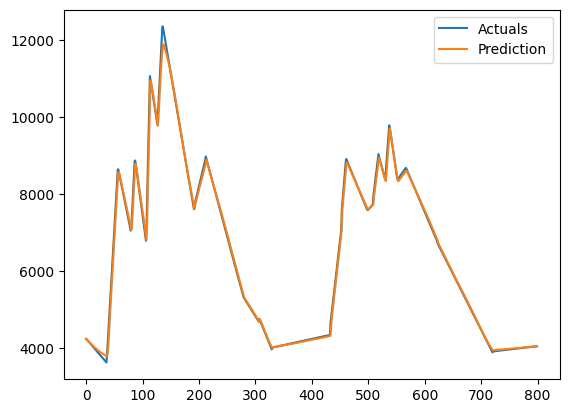

In [14]:
import matplotlib.pyplot as plt

plt.plot(results['Actuals'])
plt.plot(results['Prediction'])
plt.legend(results, loc= "upper right")

In [15]:
valid_predict= models.predict(x_val).flatten()
results=pd.DataFrame(data={"Prediction":valid_predict, "Actuals":y_val})
results

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


,Prediction,Actuals
0,4058.181885,4060
1,4059.552979,4062
2,4061.181396,4063
3,4062.272461,4065
4,4063.650635,4067
...,...,...
295,4053.613037,4047
296,4050.636963,4044
297,4047.958252,4040
298,4045.004150,4037


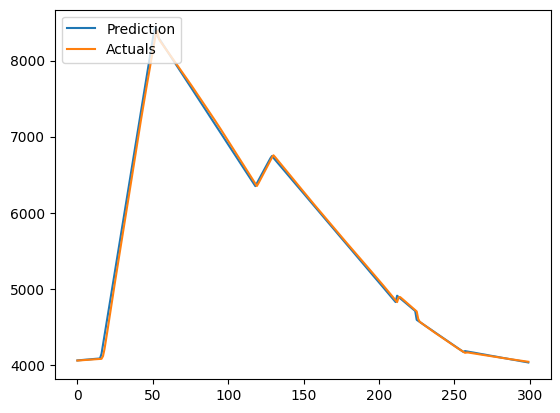

In [16]:
plt.plot(results['Actuals'])
plt.plot(results['Prediction'])
plt.legend(results, loc= "upper left")

In [ ]:
test= models.predict(x_test).flatten()
results=pd.DataFrame(data={"Actuals":y_test, "Prediction": test,})
results

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Actuals,Prediction
0,4030,4039.412842
1,4026,4036.771729
2,4022,4033.862549
3,4019,4030.718262
4,4015,4028.099365
...,...,...
345,3705,3822.881592
346,3709,3824.790771
347,3712,3826.735840
348,3716,3828.385742


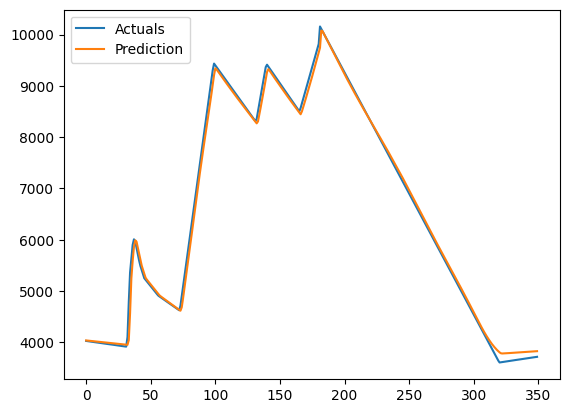

In [18]:
plt.plot(results['Actuals'])
plt.plot(results['Prediction'])
plt.legend(results, loc= "upper left")

In [ ]:
from sklearn.metrics import r2_score

true = results['Actuals']
predicted = results['Prediction']

r2_score(true, predicted)